In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

In [2]:
stock_symbol = 'BHARTIARTL.NS'
stock_data = yf.download(stock_symbol,  period="max")

[*********************100%%**********************]  1 of 1 completed


In [3]:
stock_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-07-01,15.343904,15.997316,15.096059,15.681876,14.616555,847376
2002-07-02,15.096059,16.042379,15.096059,15.997316,14.910567,676474
2002-07-03,16.222630,16.222630,15.749470,15.839596,14.763562,574661
2002-07-04,16.109974,16.335287,15.884659,16.222630,15.120574,1148300
2002-07-05,15.794533,15.974785,15.321373,15.411499,14.364547,903273
...,...,...,...,...,...,...
2024-04-25,1331.000000,1343.800049,1324.349976,1338.699951,1338.699951,8512627
2024-04-26,1338.000000,1345.699951,1322.000000,1326.000000,1326.000000,5289771
2024-04-29,1324.500000,1346.000000,1320.000000,1332.449951,1332.449951,3195888


In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt


stock_data.reset_index(inplace=True)

# Extract the 'Date' and 'Close' columns
data = stock_data[['Date', 'Close']].copy()

In [5]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[['Close']])

# Function to create dataset
def create_dataset(data, look_back=60):
    X, y = [], []
    for i in range(len(data)-look_back-1):
        X.append(data[i:(i+look_back)])
        y.append(data[i + look_back, 0])  # Close price is the label (index 0)
    return np.array(X), np.array(y)

# Create dataset with look-back window
look_back = 60  # Adjust this window size as needed
X, y = create_dataset(scaled_data, look_back)

# Reshape input data for LSTM (samples, time steps, features)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))

In [6]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
model.fit(X, y, epochs=50, batch_size=32)

Epoch 1/50
168/168 [==============================] - 17s 11ms/step - loss: 0.0036
Epoch 2/50
168/168 [==============================] - 2s 11ms/step - loss: 0.0010
Epoch 3/50
168/168 [==============================] - 2s 10ms/step - loss: 9.7576e-04
Epoch 4/50
168/168 [==============================] - 2s 10ms/step - loss: 8.0163e-04
Epoch 5/50
168/168 [==============================] - 2s 10ms/step - loss: 8.8945e-04
Epoch 6/50
168/168 [==============================] - 2s 11ms/step - loss: 6.9652e-04
Epoch 7/50
168/168 [==============================] - 2s 13ms/step - loss: 6.8309e-04
Epoch 8/50
168/168 [==============================] - 2s 10ms/step - loss: 7.1683e-04
Epoch 9/50
168/168 [==============================] - 2s 12ms/step - loss: 6.0693e-04
Epoch 10/50
168/168 [==============================] - 2s 11ms/step - loss: 5.6334e-04
Epoch 11/50
168/168 [==============================] - 2s 10ms/step - loss: 5.3253e-04
Epoch 12/50
168/168 [==============================] - 2s 1

1/1 [==============================] - 0s 24ms/step


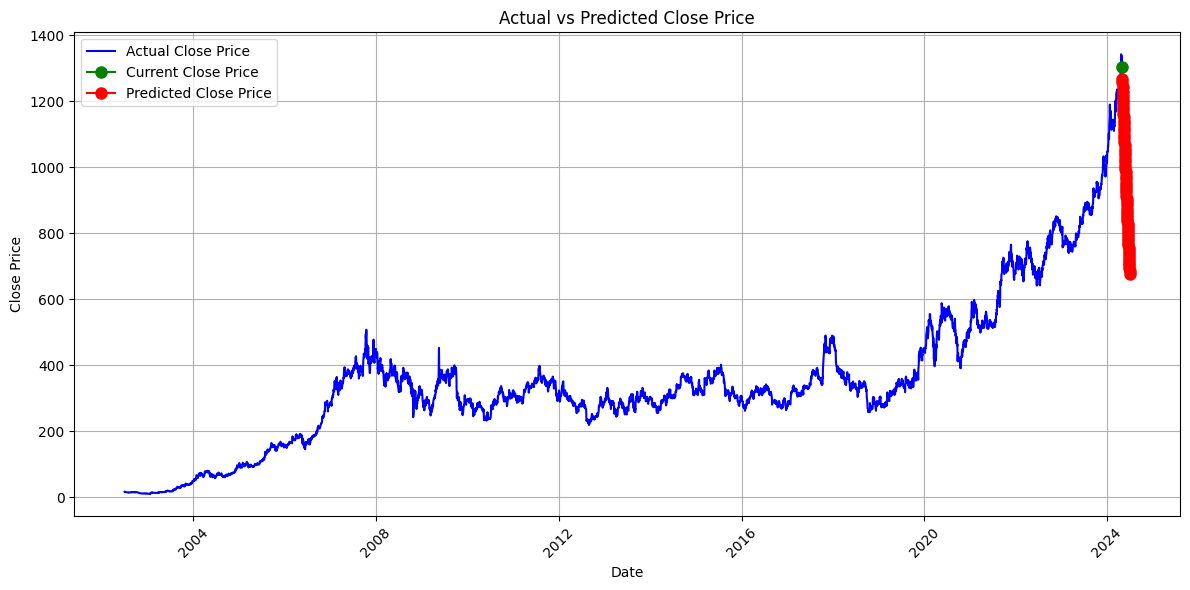

In [8]:
def predict_future_prices(model, data, look_back, num_days):
    last_sequence = data[-look_back:]  # Get the last sequence of known data
    predicted_prices = []
    for _ in range(num_days):
        prediction = model.predict(last_sequence.reshape(1, look_back, 1))  # Predict next day's price
        predicted_prices.append(prediction[0, 0])  # Append predicted price to list
        last_sequence = np.append(last_sequence[1:], prediction[0])  # Update last sequence with new prediction
    return scaler.inverse_transform(np.array(predicted_prices).reshape(-1, 1))[:, 0]

# Predict future prices for the next 20 days
num_days = 60  # Change this value to predict a different number of days into the future
predicted_prices = predict_future_prices(model, scaled_data, look_back, num_days)

# Plot actual and predicted closing prices
plt.figure(figsize=(12, 6))
plt.plot(data['Date'], scaler.inverse_transform(scaled_data), label='Actual Close Price', color='blue')
plt.plot(data['Date'].iloc[-1:], scaler.inverse_transform(scaled_data)[-1:], marker='o', markersize=8, color='green', label='Current Close Price')
plt.plot(pd.date_range(start=data['Date'].iloc[-1], periods=num_days+1, freq='D')[1:], predicted_prices, marker='o', markersize=8, color='red', label='Predicted Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Actual vs Predicted Close Price')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
predicted_prices

array([1268.7855 , 1257.0092 , 1242.8339 , 1228.9126 , 1216.1276 ,
       1204.4275 , 1193.4723 , 1182.9277 , 1172.5546 , 1162.2092 ,
       1151.8204 , 1141.3625 , 1130.8369 , 1120.2578 , 1109.6451 ,
       1099.018  , 1088.3939 , 1077.7866 , 1067.2069 , 1056.6619 ,
       1046.1562 , 1035.6935 , 1025.2751 , 1014.9018 , 1004.5743 ,
        994.2925 ,  984.0566 ,  973.86664,  963.7229 ,  953.6258 ,
        943.5757 ,  933.57336,  923.6195 ,  913.71497,  903.86084,
        894.058  ,  884.3077 ,  874.611  ,  864.96924,  855.3836 ,
        845.8554 ,  836.38605,  826.97687,  817.6293 ,  808.3447 ,
        799.1246 ,  789.9704 ,  780.8836 ,  771.8657 ,  762.9182 ,
        754.0425 ,  745.24023,  736.5127 ,  727.8616 ,  719.2882 ,
        710.79395,  702.3804 ,  694.0488 ,  685.80054,  677.637  ],
      dtype=float32)

In [10]:
model.save('BHARTIARTL.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [11]:
import joblib
joblib.dump(scaler, 'BHARTIARTL.pkl')

['BHARTIARTL.pkl']